## Setup

In [1]:
# RUN SETUP.SH BEFORE RUNNING THIS IPYNB
# REQUIREMENTS FOR SETUP.SH:
# python 3.11.8
# pip 23.3.1

import pandas as pd
import pickle
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression Classifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN, RandomOverSampler
from scipy.sparse import hstack, csr_matrix, save_npz, load_npz
import spacy
import re
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif
import nltk
from readability import Readability
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from collections import Counter
import csv


In [2]:
SEED = 42 # seed random state for comparison, testing
PARTITION_SIZE = 500 # Adjust lower if potato PC and higher if gaming rig or want results closer to actual
enable_all_data = True # SET TO FALSE IF PREPROCESSING TAKES A LONG TIME (True = test on PARTITION_SIZE training and PARTITION_SIZE testing samples)
enable_features_from_savefile = True
enable_validation_data = False
enable_model_from_savefile = True

## Pre-processing

In [3]:
df = pd.read_csv('../raw_data/fulltrain.csv', header=None, index_col = False)
# df.head()

In [4]:
df = df if enable_all_data else df.sample(n=PARTITION_SIZE, random_state=SEED)

X_train = df.iloc[:, 1] 
y_train = df.iloc[:, 0]

# print(X_train)
# print(y_train)

# print(len(X_train))
# print(len(y_train))

# y_train.value_counts()

### Train-Validation Split

In [5]:
if enable_validation_data:
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

### Feature analysis

In [6]:
def count_analysis_bar(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].bar(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_scatter(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].scatter(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_boxplot(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals = np.unique(counts_i)
        axs[i-1].boxplot(unique_vals)
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

### Feature Engineering

In [7]:
# Feature set:
# 1) TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [8]:
# Consolidation of feature sets into single vector:
X_train_filename = "tfidf"
if enable_features_from_savefile:
    # Load features as sparse matrix (Download file from Google Drive)
    X_train = load_npz(f"{X_train_filename}.npz")
else:
    X_train = hstack([X_train_tfidf])
    save_npz(f"{X_train_filename}.npz", X_train)

### Scaler

In [9]:
# scaler = MaxAbsScaler() # Sparse matrix
# X_train = scaler.fit_transform(X_train)

### Feature selection: SelectPercentile

In [10]:
# Take top 10% of features by scores
# feature_selector = SelectPercentile(f_classif)
# X_train = feature_selector.fit_transform(X_train, y_train)

### Oversampling

In [11]:
# RandomOverSampler
ros = RandomOverSampler(random_state=SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

## Models

### Logistic Regression Model [LogisticRegression]

In [12]:
model_path = 'LogisticRegression-tfidf-randomoversampler.pkl'
if not enable_model_from_savefile:
    model = LogisticRegression(solver = 'saga', max_iter=3000).fit(X_train, y_train)
    # Save model
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
else:
    # Load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

## Validation

In [13]:
# Apply feature engineering on X_val
if enable_validation_data:
    X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [14]:
# Consolidation of feature sets:
if enable_validation_data:
    X_val_final = hstack([X_val_tfidf])
    # X_val_final = scaler.transform(X_val_final)
    # X_val_final = feature_selector.transform(X_val_final)

In [15]:
# # obtain predictions on validation data
if enable_validation_data:
    y_val_predicted = model.predict(X_val_final)

    # evaluate model training metrics with macro f1 score
    f1_score(y_val, y_val_predicted, average='macro')

## Test Data

In [16]:
# TEST DATA 
test_df = pd.read_csv('../raw_data/balancedtest.csv', index_col = False)
test_df = test_df if enable_all_data else test_df.sample(PARTITION_SIZE, random_state=SEED)

In [17]:
X_test = test_df.iloc[:, 1]
y_test = test_df.iloc[:, 0]

# print(X_test.head())
# print(y_test.head())

### Feature Engineering (Test Data)

In [18]:
# Apply feature engineering on X_test
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [19]:
# Consolidation of feature transformations into single vector
X_test_final = hstack([X_test_tfidf])
# X_test_final = scaler.transform(X_test_final)
# X_test_final = feature_selector.transform(X_test_final)

### Metrics

#### Accuracy, precision, recall, F1

In [20]:
# obtain predictions on test data
y_pred = model.predict(X_test_final)

# evaluate model training metrics with macro f1 score
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_pred)

In [21]:
print(f'Test Accuracy: {test_accuracy:.8f},\tTest Precision: {test_precision:.8f},\tTest Recall: {test_recall:.8f},\tTest F1: {test_f1:.8f}')

class_test_precision, class_test_recall, class_test_f1, class_ = precision_recall_fscore_support(y_test, y_pred)
for i in range(4):
    print(f'Class {i}:\tTest Precision: {class_test_precision[i]:.8f},\tTest Recall: {class_test_recall[i]:.8f},\tTest f1: {class_test_f1[i]:.8f}')

pd.Series(y_pred).value_counts()

Test Accuracy: 0.75125042,	Test Precision: 0.76261161,	Test Recall: 0.75126569,	Test F1: 0.74326321
Class 0:	Test Precision: 0.84921764,	Test Recall: 0.79706275,	Test f1: 0.82231405
Class 1:	Test Precision: 0.79912664,	Test Recall: 0.48800000,	Test f1: 0.60596026
Class 2:	Test Precision: 0.64861878,	Test Recall: 0.78266667,	Test f1: 0.70936556
Class 3:	Test Precision: 0.75348339,	Test Recall: 0.93733333,	Test f1: 0.83541295


4    933
3    905
1    703
2    458
Name: count, dtype: int64

## Tackling Generalizability

#### Feature selection percentage - coefficients for each feature

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

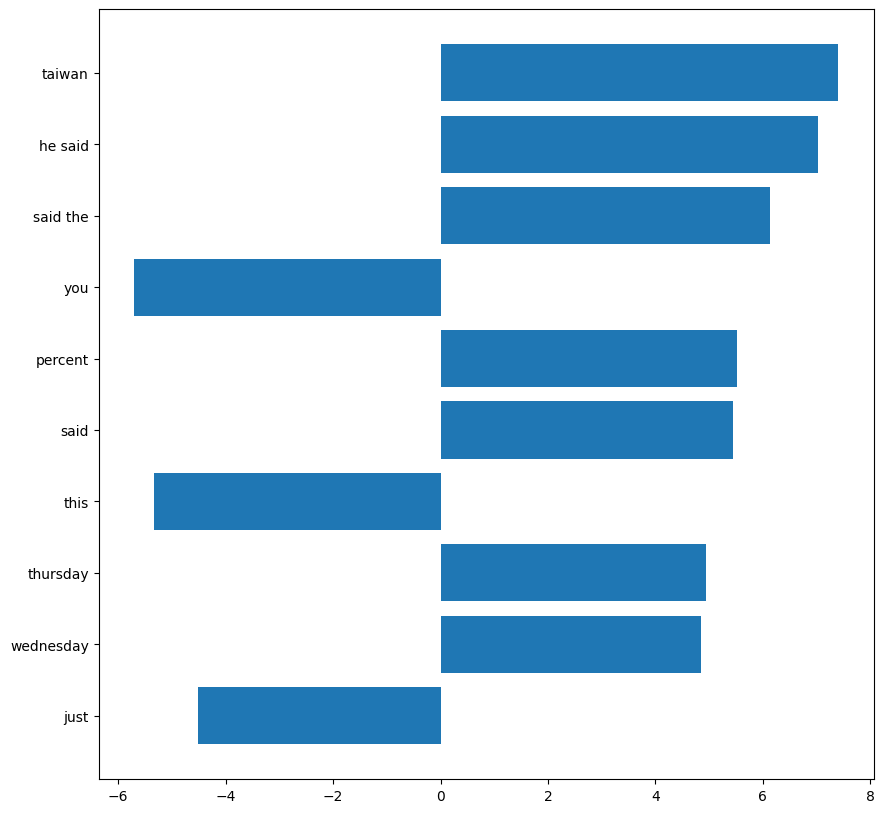

In [22]:
# Get all column names for features
feature_names = np.empty(0)
feature_names = np.concatenate((feature_names, tfidf_vectorizer.get_feature_names_out()))

# Get coefficients for Logistic Regression
labels_coefficients = model.coef_
NUM_HIGHEST_ABS_COEFF = 10
row = 1
for label_coefficients in labels_coefficients:
    plt.clf()
    plt.figure(figsize=(10, 10))
    label_coefficients_abs = np.abs(label_coefficients)
    top_indices = np.argsort(label_coefficients_abs)[-NUM_HIGHEST_ABS_COEFF:]
    top_feature_names = feature_names[top_indices]
    top_coeffs = label_coefficients[top_indices]
    plt.barh(top_feature_names, top_coeffs)
    plt.savefig(f"Best-features-coeff-label-{row}.png")
    row += 1


#### Rejection of classification - rejection by probability threshold

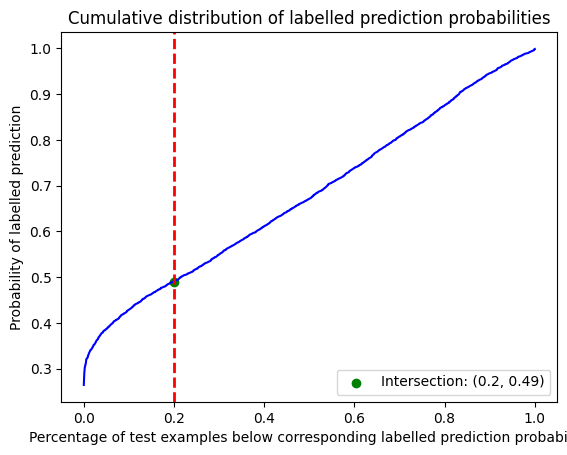

In [23]:
REJECTION_PERCENTAGE = 0.2 # percentage of examples that are rejected 

y_pred_prob = model.predict_proba(X_test_final)
y_pred_prob_max = np.sort(np.max(y_pred_prob, axis=1))
x_range = np.arange(1, len(y_pred_prob_max) + 1) / len(y_pred_prob_max)

rejection_index = int(len(y_pred_prob_max) * REJECTION_PERCENTAGE)
labelled_prediction_rejection_prob = y_pred_prob_max[rejection_index]

plt.plot(x_range, y_pred_prob_max, color='b')
plt.axvline(REJECTION_PERCENTAGE, color='r', linestyle='--', linewidth=2)
plt.scatter(REJECTION_PERCENTAGE, labelled_prediction_rejection_prob, color='green', label=f'Intersection: ({REJECTION_PERCENTAGE}, {labelled_prediction_rejection_prob:.2f})')
plt.legend()
plt.xlabel('Percentage of test examples below corresponding labelled prediction probability')
plt.ylabel('Probability of labelled prediction')
plt.title('Cumulative distribution of labelled prediction probabilities')
plt.savefig("rejection-probability-threshold-randomoversampler.png")
plt.show()

#### Rejection of classification - rejection by distance in document embedding space

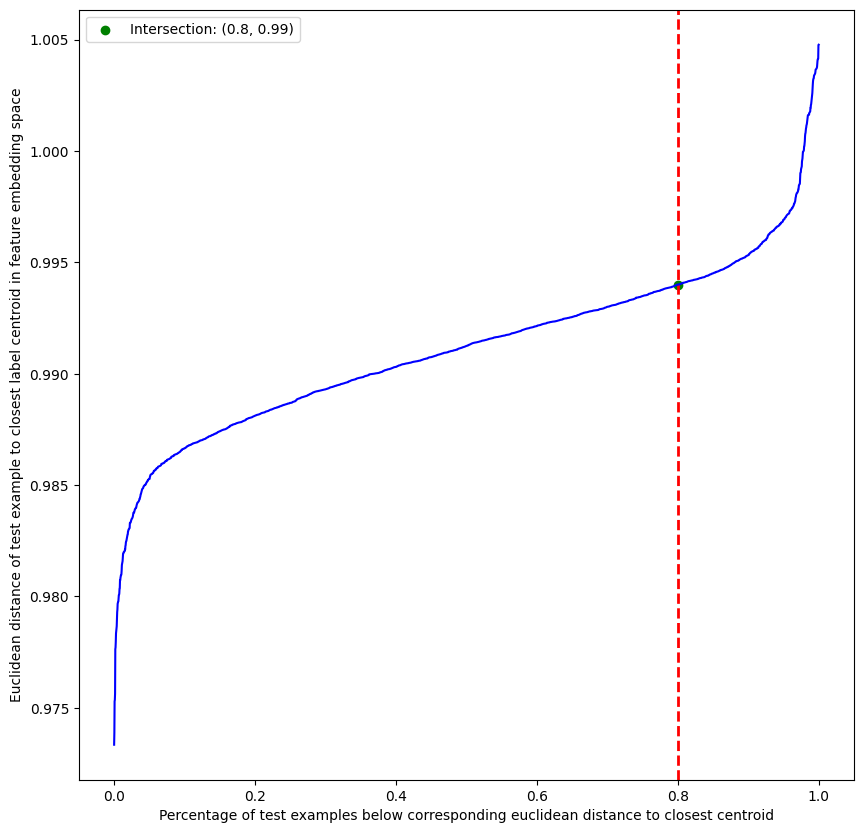

In [24]:
# 1) Filter by y_train
# 2) mean on each column for each labels "centroid"
# 3) Find distance from "centroid" to current
unique_labels = np.unique(y_train)
mean_labels = np.zeros((len(unique_labels), X_train.shape[1]))

row = 0
for label in unique_labels:
    indices = y_train.index[y_train == label]
    points = X_train[indices]
    label_mean_point = points.mean(axis=0)
    mean_labels[row] = label_mean_point
    row += 1
    
distances = pairwise_distances(X_test_final, mean_labels, metric='euclidean')
min_distances = np.min(distances, axis=1)
min_distances = min_distances.flatten()
min_distances.sort()

x_range = np.arange(1, len(min_distances) + 1) / len(min_distances)
rejection_index = int(len(min_distances) * (1 - REJECTION_PERCENTAGE))
euc_dist_rejection_boundary = min_distances[rejection_index]

plt.figure(figsize=(10, 10))
plt.axvline(1 - REJECTION_PERCENTAGE, color='r', linestyle='--', linewidth=2)
plt.scatter(1 - REJECTION_PERCENTAGE, euc_dist_rejection_boundary, color='green', label=f'Intersection: ({1 - REJECTION_PERCENTAGE}, {euc_dist_rejection_boundary:.2f})')
plt.legend()
plt.plot(x_range, min_distances, color='b')
plt.xlabel('Percentage of test examples below corresponding euclidean distance to closest centroid')
plt.ylabel('Euclidean distance of test example to closest label centroid in feature embedding space')
plt.savefig("rejection-euclidean-distance-randomoversampler.png")
plt.show()